In [ ]:
!pip install -q dgl-cu116 dglgo -f https://data.dgl.ai/wheels/repo.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.3/246.3 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.4/519.4 kB 35.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 570.5/570.5 kB 21.4 MB/s eta 0:0

In [ ]:
import os
os.environ['DGLBACKEND'] = 'pytorch'

import networkx as nx
import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.nn import init
import torch.nn.functional as func

import dgl
import dgl.data
import dgl.ops as F
import dgl.function as fn
from dgl.utils import expand_as_pair

# Graph Representation

We can load graphs from networkx or we can define them ourselves with DGL

First list with nodes is the **source** nodes in the edge and second list is the **destination** nodes in the edge.

I.e. a directed node from node 0 to 5 would have 0 in the first list and 5 in the second list

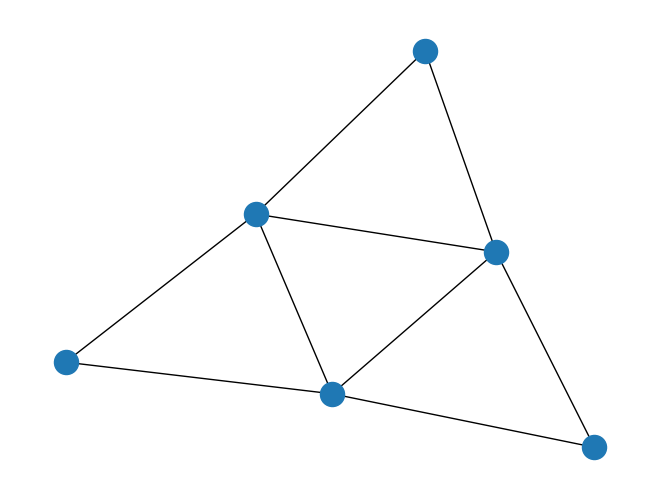

In [ ]:
G = nx.dorogovtsev_goltsev_mendes_graph(2)
nx.draw(G)

In [ ]:
g = dgl.from_networkx(G)
g

Graph(num_nodes=6, num_edges=18,
      ndata_schemes={}
      edata_schemes={})

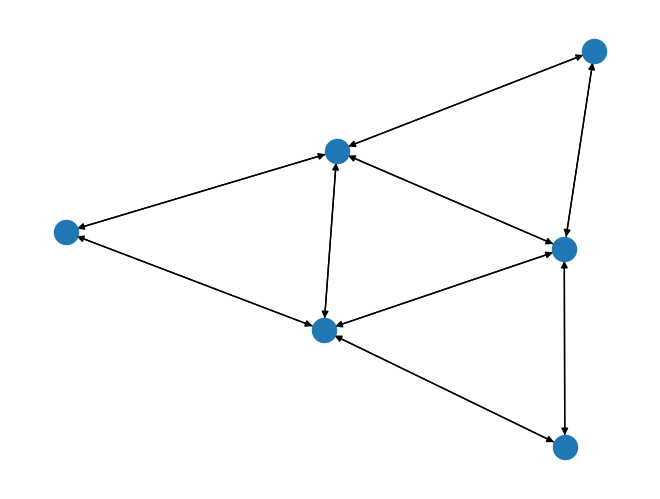

In [ ]:
nx.draw(dgl.to_networkx(g))

In [ ]:
# Standard Definition
g = dgl.graph(([0, 0, 0, 0, 0], [1, 2, 3, 4, 5]), num_nodes=6)
# Using Pytorch Longtensors
g = dgl.graph(
    (torch.LongTensor([0, 0, 0, 0, 0]), torch.LongTensor([1, 2, 3, 4, 5])),
    num_nodes=6,
)
# You can omit the node count if it can be determined from the edge list
g = dgl.graph(([0, 0, 0, 0, 0], [1, 2, 3, 4, 5]))
g

Graph(num_nodes=6, num_edges=5,
      ndata_schemes={}
      edata_schemes={})

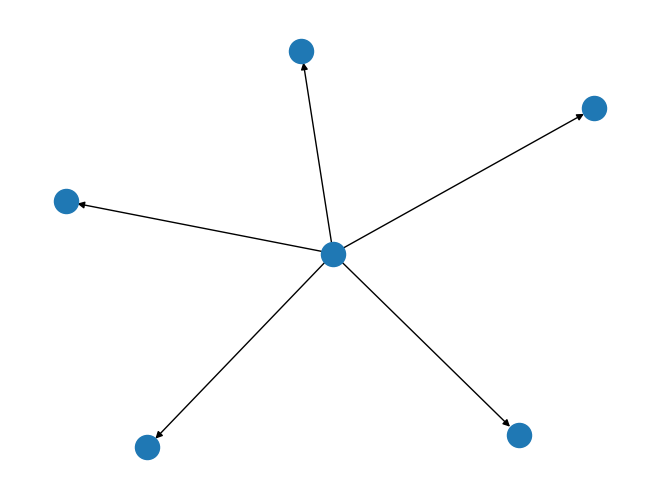

In [ ]:
G = dgl.to_networkx(g)
nx.draw(G)

For node features and edge features, we store them in ndata and edata

In [ ]:
g.nodes()

tensor([0, 1, 2, 3, 4, 5])

In [ ]:
g.edges()

(tensor([0, 0, 0, 0, 0]), tensor([1, 2, 3, 4, 5]))

In [ ]:
g.ndata['feature'] = torch.from_numpy(np.random.rand(6,4))
g.ndata['label'] = torch.from_numpy(np.random.rand(6,1))

In [ ]:
print(g.ndata['feature'])

tensor([[0.1261, 0.1689, 0.6532, 0.9916],
        [0.4615, 0.0725, 0.0583, 0.2682],
        [0.4076, 0.6325, 0.4380, 0.0116],
        [0.2692, 0.2723, 0.6286, 0.1974],
        [0.6447, 0.4328, 0.8124, 0.1770],
        [0.8121, 0.7109, 0.9085, 0.9916]], dtype=torch.float64)


In [ ]:
g.edata['feature'] = torch.from_numpy(np.random.rand(5,4))
g.edata['label'] = torch.from_numpy(np.random.rand(5,2))
print(g.edata['feature'])

tensor([[0.0762, 0.2827, 0.7657, 0.3165],
        [0.1142, 0.4730, 0.6964, 0.0371],
        [0.6680, 0.7325, 0.8422, 0.3328],
        [0.4871, 0.9126, 0.7766, 0.5868],
        [0.8620, 0.4425, 0.7033, 0.8779]], dtype=torch.float64)


Can put arbritary names for now, can feed these features in the model later

# Data Loading

DGL provides numerous sample datasets which you can try on your own

[List of datasets](https://docs.dgl.ai/api/python/dgl.data.html)

Here is an example of the Cora Dataset, which is a citation dataset. The papers are the nodes and the edges are the citations between the nodes. It is a single graph dataset.

In [ ]:
dataset = dgl.data.CoraGraphDataset()
print('Number of categories:', dataset.num_classes)

Extracting file to /root/.dgl/cora_v2
Finished data loading and preprocessing.
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.
Number of categories: 7


The graph is stored in dataset as dataset[0]

In [ ]:
g = dataset[0]
g

Graph(num_nodes=2708, num_edges=10556,
      ndata_schemes={'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool), 'label': Scheme(shape=(), dtype=torch.int64), 'feat': Scheme(shape=(1433,), dtype=torch.float32)}
      edata_schemes={})

We can see the feature data and the labels.
Data in DGL is always stored **row-wise**

In [ ]:
g.ndata['feat']

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [ ]:
g.ndata['label']

tensor([3, 4, 4,  ..., 3, 3, 3])

We can also define our own datasets. A self-defined dataset in DGL must overload **\_\_init\_\_**, **process**, **\_\_getitem\_\_** and **\_\_len\_\_**

**\_\_init\_\_(self)** is just for naming the class

**process(self)** is for data loading and setting up of the data

**\_\_getitem\_\_(self, i)** returns the ith graph in the dataset

**\_\_len\_\_(self)** returns the number of graphs in the dataset

In [ ]:
class LSPDataset(dgl.data.DGLDataset):
    def __init__(self):
        super().__init__(name='lsp')

    def process(self):
        self.graphs = []

    def __getitem__(self, i):
        return self.graphs[i]

    def __len__(self):
        return len(self.graphs)

# Model Definition

DGL provides implementation for all the commonly used GNN architectures such as some covered in our lesson

**SAGEConv** -> GraphSage architecture

**GATConv** -> Graph Attention Network

**ChebConv** -> Chebyschev Network

**GraphConv** -> Graph Convolutional Network (GCN)

[Full list of models](https://docs.dgl.ai/api/python/nn-pytorch.html)


## Building your own GNN

One can also define there on models and DGL provides some useful tools to improve efficiency of implementation in **dgl.ops** and **dgl.function**

In [ ]:
g = dgl.graph(([0, 0, 0, 1, 1, 2], [0, 1, 2, 1, 2, 2]))
g.ndata["feat"] = torch.arange(2, 8).float().view(3, 2).requires_grad_()
g.edata["weight"] = torch.arange(1,7).float().requires_grad_()

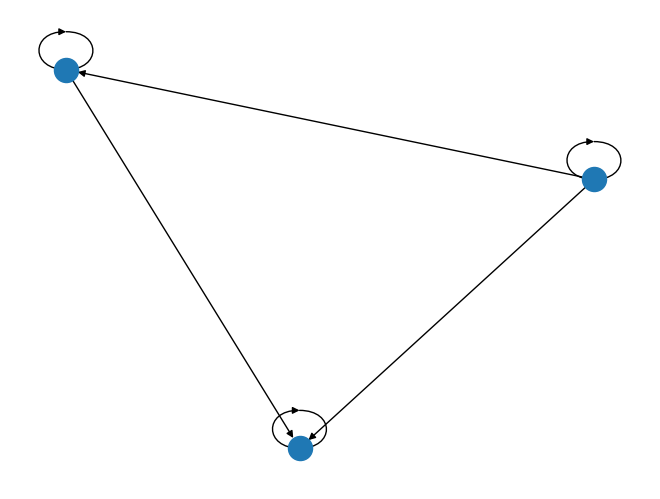

In [ ]:
G = dgl.to_networkx(g)
nx.draw(G)

In [ ]:
g.ndata["feat"]

tensor([[2., 3.],
        [4., 5.],
        [6., 7.]], requires_grad=True)

In [ ]:
g.edges()

(tensor([0, 0, 0, 1, 1, 2]), tensor([0, 1, 2, 1, 2, 2]))

In [ ]:
g.edata["weight"]

tensor([1., 2., 3., 4., 5., 6.], requires_grad=True)

### GSpMM functions (example with DGL Ops)

Generalized Sparse-Matrix Dense-Matrix Multiplication functions. It fuses two steps into one kernel.

1. Computes messages by add/sub/mul/div source node and edge features, or copy node features to edges.

2. Aggregate the messages by sum/max/min/mean as the features on destination nodes.

In [ ]:
# [2, 3] = 1 * [2, 3]
# [20, 26] = 2 * [2, 3] + 4 * [4, 5]
# [62, 76] = 3 * [2, 3] + 5 * [4, 5] + 6 * [6, 7]

F.u_mul_e_sum(g, g.ndata["feat"], g.edata["weight"])

/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:352: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), "Cannot convert view " \


tensor([[ 2.,  3.],
        [20., 26.],
        [62., 76.]], grad_fn=<GSpMMBackward>)

### GSDDMM functions (example with DGL function)

Generalized Sampled Dense-Dense Matrix Multiplication. 

It computes edge features by add/sub/mul/div/dot features on source/destination nodes or edges.

In [ ]:
# Mailbox message passing, we use "m" as the mailbox between, the data features
# ndata and edata are shared and by passing in 'feat', we access g.ndata['feat']
# We store the value "m" in a mailbox attatched to the node data
# We then access it later
propagation_function = fn.u_mul_e('feat', 'weight', 'm')
def karimi_pooling_function(nodes):
    return {'feat': torch.sum(nodes.mailbox['m'], dim=1) + 1}

In [ ]:
g.update_all(propagation_function, karimi_pooling_function)

In [ ]:
g.ndata['feat']

tensor([[ 3.,  4.],
        [21., 27.],
        [63., 77.]], grad_fn=<IndexCopyBackward0>)

Use **GSDDMM** when you want to define your own custom aggregation function.

Use **GSpMM** when you are fine using sum, max, min or mean for aggregation.

### Making your own GNN layer (actually)

A GNN architecture I made up

$$h_i^{(l+1)} = \sigma \left (|N_i|W_1^{(l)}h_i^{(l)} + b^{(l)} - \sum_{j \in N_i}W_2^{(l)}h_j^{(l)} \right )$$

If their are edge weights,

$$h_i^{(l+1)} = \sigma \left (|N_i|W_1^{(l)}h_i^{(l)} + b^{(l)} - \sum_{j \in N_i}e_{ji}W_2^{(l)}h_j^{(l)} \right )$$

Note: This is simply a spatial GNN with a varitation

$$X'=DX\Phi - AX\Theta$$

In [ ]:
class BBCSConv(nn.Module):
    def __init__(self, in_feats, out_feats, activation = None):
        super(BBCSConv, self).__init__()
        self._in_feats = in_feats
        self._out_feats = out_feats
        # Defining weights
        self.weight_1 = nn.Parameter(torch.Tensor(in_feats, out_feats))
        self.weight_2 = nn.Parameter(torch.Tensor(in_feats, out_feats))
        self.bias = nn.Parameter(torch.Tensor(out_feats))
        # Setting values
        self.reset_parameters()
        # Optional activation
        self._activation = activation

    def reset_parameters(self):
        init.xavier_uniform_(self.weight_1)
        init.xavier_uniform_(self.weight_2)
        init.zeros_(self.bias)

    def forward(self, graph, feat, edge_weight = None):
        # Defining the function for aggregation, based on whether we have edge 
        # weights or not
        half_aggregation_function = fn.copy_u('h', 'm')
        if edge_weight is not None:
            graph.edata['_edge_weight'] = edge_weight
            half_aggregation_function = fn.u_mul_e('h', '_edge_weight', 'm')
        
        # This just stores 2 copy of the node features based on the nodes 
        # changed more needed for directed context 
        feat_src, feat_dst = expand_as_pair(feat, graph)

        # Aggregation of the sum of DXW and AXW
        graph.srcdata['Nh'] = torch.matmul(feat_src * graph.in_degrees()[:, None], self.weight_1)
        graph.srcdata['h'] = torch.matmul(feat_src, self.weight_2)
        graph.update_all(half_aggregation_function, fn.sum('m', 'h'))

        # Final aggregation step
        rst = graph.dstdata['Nh'] + self.bias - graph.dstdata['h']

        # Optional non- 
        if self._activation is not None:
            rst = self._activation(rst)
        return rst

## Composite Model

We can define a model by adding different graph neural network and interleave it with the 

In [ ]:
from dgl.nn import GraphConv

class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = func.relu(h)
        h = self.conv2(g, h)
        return h


# Create the model with given dimensions
model = GCN(g.ndata["feat"].shape[1], 16, dataset.num_classes)

# Node Classification Task

In [ ]:
dataset = dgl.data.CoraGraphDataset()
g = dataset[0]

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [ ]:
def train(g, model):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    best_val_acc = 0
    best_test_acc = 0

    features = g.ndata["feat"]
    labels = g.ndata["label"]
    train_mask = g.ndata["train_mask"]
    val_mask = g.ndata["val_mask"]
    test_mask = g.ndata["test_mask"]
    for e in range(100):
        # Forward
        logits = model(g, features)

        # Compute prediction
        pred = logits.argmax(1)

        # Compute loss
        # Note that you should only compute the losses of the nodes in the training set.
        loss = func.cross_entropy(logits[train_mask], labels[train_mask])

        # Compute accuracy on training/validation/test
        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
        val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
        test_acc = (pred[test_mask] == labels[test_mask]).float().mean()

        # Save the best validation accuracy and the corresponding test accuracy.
        if best_val_acc < val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % 5 == 0:
            print(
                "In epoch {}, loss: {:.3f}, val acc: {:.3f} (best {:.3f}), test acc: {:.3f} (best {:.3f})".format(
                    e, loss, val_acc, best_val_acc, test_acc, best_test_acc
                )
            )

In [ ]:
# Create the model with given dimensions
model = GCN(g.ndata["feat"].shape[1], 16, dataset.num_classes)
train(g, model)

In epoch 0, loss: 1.945, val acc: 0.074 (best 0.074), test acc: 0.077 (best 0.077)
In epoch 5, loss: 1.891, val acc: 0.434 (best 0.434), test acc: 0.442 (best 0.421)
In epoch 10, loss: 1.807, val acc: 0.552 (best 0.552), test acc: 0.524 (best 0.524)
In epoch 15, loss: 1.699, val acc: 0.588 (best 0.588), test acc: 0.591 (best 0.591)
In epoch 20, loss: 1.569, val acc: 0.600 (best 0.600), test acc: 0.610 (best 0.610)
In epoch 25, loss: 1.421, val acc: 0.620 (best 0.620), test acc: 0.633 (best 0.633)
In epoch 30, loss: 1.261, val acc: 0.646 (best 0.646), test acc: 0.650 (best 0.650)
In epoch 35, loss: 1.096, val acc: 0.674 (best 0.674), test acc: 0.669 (best 0.669)
In epoch 40, loss: 0.935, val acc: 0.690 (best 0.690), test acc: 0.688 (best 0.688)
In epoch 45, loss: 0.784, val acc: 0.700 (best 0.700), test acc: 0.713 (best 0.710)
In epoch 50, loss: 0.649, val acc: 0.714 (best 0.714), test acc: 0.732 (best 0.732)
In epoch 55, loss: 0.534, val acc: 0.728 (best 0.728), test acc: 0.747 (best 0

# Link Prediction and Edge Classification Task

Loading dataset

Splitting data into training and testing set

In [ ]:
import scipy.sparse as sp

# Split edge set for training and testing
u, v = g.edges()

eids = np.arange(g.number_of_edges())
eids = np.random.permutation(eids)
test_size = int(len(eids) * 0.1)
train_size = g.number_of_edges() - test_size
test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]

# Find all negative edges and split them for training and testing
adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())))
adj_neg = 1 - adj.todense() - np.eye(g.number_of_nodes())
neg_u, neg_v = np.where(adj_neg != 0)

neg_eids = np.random.choice(len(neg_u), g.number_of_edges())
test_neg_u, test_neg_v = (
    neg_u[neg_eids[:test_size]],
    neg_v[neg_eids[:test_size]],
)
train_neg_u, train_neg_v = (
    neg_u[neg_eids[test_size:]],
    neg_v[neg_eids[test_size:]],
)


# Remove edges from test set
train_g = dgl.remove_edges(g, eids[:test_size])

Constructing the GraphSAGE model

In [ ]:
from dgl.nn import SAGEConv

# build a two-layer GraphSAGE model
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, "mean")  # insert the convolutions
        self.conv2 = SAGEConv(h_feats, h_feats, "mean")   # insert the convolutions

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)  # call first convolution
        h = F.relu(h)  # call an activation function 
        h = self.conv2(g, h)  # call second convolution
        return h

Constructs the positive graph and the negative graph for the training set and the test set respectively.

In [ ]:
train_pos_g = dgl.graph(
    (train_pos_u, train_pos_v), num_nodes=g.number_of_nodes()
)
train_neg_g = dgl.graph(
    (train_neg_u, train_neg_v), num_nodes=g.number_of_nodes()
)

test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes())
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes())

Layer to compute if the edge exists by taking the dot product of 2 node embeddings.

In [ ]:
import dgl.function as fn


class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata["h"] = h
            # Compute a new edge feature named 'score' by a dot-product between the
            # source node feature 'h' and destination node feature 'h'.
            g.apply_edges(fn.u_dot_v("h", "h", "score"))  # compute dot product

            # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata["score"][:, 0]

Construct the final model.

In [ ]:
import torch.nn.functional as F

model = GraphSAGE(train_g.ndata["feat"].shape[1], 16)
pred = DotPredictor()

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]
    )
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]
    ).numpy()
    return roc_auc_score(labels, scores)


Training the model

In [ ]:
import itertools

optimizer = torch.optim.Adam(
    itertools.chain(model.parameters(), pred.parameters()), lr=0.01
)

all_logits = []
for e in range(100):
    # forward
    h = model(train_g, train_g.ndata["feat"])
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if e % 5 == 0:
        print("In epoch {}, loss: {}".format(e, loss))

/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:352: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), "Cannot convert view " \


In epoch 0, loss: 0.6930118203163147
In epoch 5, loss: 0.6668325662612915
In epoch 10, loss: 0.5817569494247437
In epoch 15, loss: 0.5276401042938232
In epoch 20, loss: 0.48581451177597046
In epoch 25, loss: 0.46147507429122925
In epoch 30, loss: 0.43305715918540955
In epoch 35, loss: 0.4095371961593628
In epoch 40, loss: 0.3882129192352295
In epoch 45, loss: 0.3670193552970886
In epoch 50, loss: 0.34659698605537415
In epoch 55, loss: 0.32595545053482056
In epoch 60, loss: 0.3046725392341614
In epoch 65, loss: 0.2837223708629608
In epoch 70, loss: 0.26255640387535095
In epoch 75, loss: 0.24162235856056213
In epoch 80, loss: 0.22076880931854248
In epoch 85, loss: 0.20012833178043365
In epoch 90, loss: 0.17971603572368622
In epoch 95, loss: 0.159995436668396


Compute the ROC AUC score

In [ ]:
from sklearn.metrics import roc_auc_score

with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    print("AUC", compute_auc(pos_score, neg_score))
    

AUC 0.8689328631432359


/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:352: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), "Cannot convert view " \


# Graph Classifcation Task

Loading the dataset

In [ ]:
# Generate a synthetic dataset with 10000 graphs, ranging from 10 to 500 nodes.
dataset = dgl.data.GINDataset("PROTEINS", self_loop=True)

print("Node feature dimensionality:", dataset.dim_nfeats)
print("Number of graph categories:", dataset.gclasses)

Extracting file to /root/.dgl/GINDataset
Node feature dimensionality: 3
Number of graph categories: 2


Building the data loader

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler

from dgl.dataloading import GraphDataLoader

num_examples = len(dataset)
num_train = int(num_examples * 0.8)

train_sampler = SubsetRandomSampler(torch.arange(num_train))
test_sampler = SubsetRandomSampler(torch.arange(num_train, num_examples))

train_dataloader = GraphDataLoader(
    dataset, sampler=train_sampler, batch_size=5, drop_last=False
)
test_dataloader = GraphDataLoader(
    dataset, sampler=test_sampler, batch_size=5, drop_last=False
)

Constructing the batches

In [ ]:
it = iter(train_dataloader)
batch = next(it)
print(batch)

[Graph(num_nodes=123, num_edges=581,
      ndata_schemes={'label': Scheme(shape=(), dtype=torch.int64), 'attr': Scheme(shape=(3,), dtype=torch.float32)}
      edata_schemes={}), tensor([0, 0, 0, 0, 1])]


In [ ]:
batched_graph, labels = batch
print(
    "Number of nodes for each graph element in the batch:",
    batched_graph.batch_num_nodes(),
)
print(
    "Number of edges for each graph element in the batch:",
    batched_graph.batch_num_edges(),
)

# Recover the original graph elements from the minibatch
graphs = dgl.unbatch(batched_graph)
print("The original graphs in the minibatch:")
print(graphs)

Number of nodes for each graph element in the batch: tensor([34, 50, 17, 12, 10])
Number of edges for each graph element in the batch: tensor([166, 246,  73,  52,  44])
The original graphs in the minibatch:
[Graph(num_nodes=34, num_edges=166,
      ndata_schemes={'label': Scheme(shape=(), dtype=torch.int64), 'attr': Scheme(shape=(3,), dtype=torch.float32)}
      edata_schemes={}), Graph(num_nodes=50, num_edges=246,
      ndata_schemes={'label': Scheme(shape=(), dtype=torch.int64), 'attr': Scheme(shape=(3,), dtype=torch.float32)}
      edata_schemes={}), Graph(num_nodes=17, num_edges=73,
      ndata_schemes={'label': Scheme(shape=(), dtype=torch.int64), 'attr': Scheme(shape=(3,), dtype=torch.float32)}
      edata_schemes={}), Graph(num_nodes=12, num_edges=52,
      ndata_schemes={'label': Scheme(shape=(), dtype=torch.int64), 'attr': Scheme(shape=(3,), dtype=torch.float32)}
      edata_schemes={}), Graph(num_nodes=10, num_edges=44,
      ndata_schemes={'label': Scheme(shape=(), dtype=tor

Build the graph convolutional network

In [ ]:
from dgl.nn import GraphConv


class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)  # insert graph convolution 1
        self.conv2 = GraphConv(h_feats, num_classes)  # insert graph convolution 2

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)  # call first convolution
        h = F.relu(h)  # call an activation function
        h = self.conv2(g, h)  # call second convolution
        g.ndata["h"] = h
        return dgl.mean_nodes(g, "h")  # pooling function

Training the model

In [ ]:
# Create the model with given dimensions
model = GCN(dataset.dim_nfeats, 16, dataset.gclasses)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(20):
    for batched_graph, labels in train_dataloader:
        pred = model(batched_graph, batched_graph.ndata["attr"].float())
        loss = F.cross_entropy(pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

num_correct = 0
num_tests = 0
for batched_graph, labels in test_dataloader:
    pred = model(batched_graph, batched_graph.ndata["attr"].float())
    num_correct += (pred.argmax(1) == labels).sum().item()
    num_tests += len(labels)

print("Test accuracy:", num_correct / num_tests)

/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:352: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), "Cannot convert view " \


Test accuracy: 0.2645739910313901
